In [1]:
import os # 파이썬을 이용해 파일을 복사하거나 디렉터리를 생성하고 특정 디렉터리 내의 파일 목록을 구하고자 할 때 사용
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torchvision # torchvision package : 컴퓨터 비전을 위한 유명 데이터셋, 모델 아키텍처, 이미지 변형등을 포함
import torch.nn as nn # nn : neural netwroks (define class) attribute를 활용해 state를 저장하고 활용
import torch.optim as optim # 최적화 알고리즘
import torch.nn.functional as F # (define function) 인스턴스화 시킬 필요없이 사용 가능
from PIL import Image
from torchvision import transforms, datasets # transforms : 데이터를 조작하고 학습에 적합하게 만듦.
from torch.utils.data import Dataset, DataLoader
# dataset : 샘플과 정답(label)을 저장
# DataLoader : Dataset 을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체(iterable)로 감싼다.

In [3]:
import torch
# torch.nn : 딥러닝 모델에 필요한 모듈이 모여 있는 패키지
import torch.nn as nn

class block(nn.Module):
    # __init__는 클래스 내의 생성자라 불리고 초기화를 위한 함수이다.
    # self는 인스턴스 자신이다.
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        # super(모델명, self).__init__() 형태로 호출
        # 위처럼 호출해서 nn.Module.__init__()을 실행
        super(block, self).__init__()
        self.expansion = 4 # 확장
        # nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding) 순서로 정의
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)
        self.relu = nn.ReLU()
        # downsample은 forward시 f(x)+x의 residual을 구현할 경우 f(x)와 x의 텐서사이즈가 다를 때 사용한다.
        self.identity_downsample = identity_downsample
    
    # 네트워크 구조를 정의하는 순방향 함수
    # 여기서는 한가지 입력만 허용하고 있다.
    def forward(self, x):
        # identity에 x 저장
        identity = x
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # x(=출력값)에 identity 값 더함    
        x += identity
        x = self.relu(x)
        return x

In [2]:
class ResNet(nn.Module): # resnet50 : [3, 4, 6, 3]
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # ResNet layers
        # self._make_layer를 이용하여 residual block들을 쌓는다.
        # 필터의 개수는 각 block들을 거치면서 2배씩 늘어난다. (64->128->256->512)
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)) # (n, 512, 1, 1)의 텐서로 만든다.
        self.fc = nn.Linear(512*4, num_classes) # fully-connected layer
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1) # send it into the fully connected layer
        x = self.fc(x)
        return x
    
    # _make_layer에서 residual block 생성
    # block : 앞에 정의한 block 클래스
    # num_residual_blocks : layer 반복해서 쌓는 개수
    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []
        
        # downsampling이 필요한 경우 identity_downsample 생성
            # 1. stride가 1이 아닐 때
            # 2. self.in_channels가 out_channels*4와 크기가 맞지 않을 때
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, out_channels*4, kernel_size=1, stride=stride),
            nn.BatchNorm2d(out_channels*4))
        
        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))
        self.in_channels = out_channels*4 # 256
        
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels)) # 256 -> 64, 64*4 (256) again
        
        return nn.Sequential(*layers)

In [4]:
def ResNet50(img_channels=1, num_classes=10):
    return ResNet(block, [3, 4, 6, 3], img_channels, num_classes)

def ResNet101(img_channels=1, num_classes=10):
    return ResNet(block, [3, 4, 23, 3], img_channels, num_classes)

def ResNet152(img_channels=1, num_classes=10):
    return ResNet(block, [3, 8, 36, 3], img_channels, num_classes)

def test():
    net = ResNet101()
    x = torch.randn(2, 1, 224, 224)
    y = net(x).to('cuda')
    print(y.shape)

test()

torch.Size([2, 10])


In [5]:
my_resnet = ResNet101()

In [6]:
input = torch.randn((16,1,224,224))
output = my_resnet(input)
print(output.shape)

print(my_resnet)

# 결과

torch.Size([16, 10])
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, mo

In [7]:
epochs = 10 # 훈련 반복수
batch_size = 512 # 배치 크기

device = ("cuda" if torch.cuda.is_available() else "cpu") # device 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] # 총 10개의 클래스

print(torch.__version__)
print(device)

# 결과
# 1.10.0+cu111
# cuda

1.11.0+cu113
cuda


In [8]:
transform = transforms.Compose([
    transforms.Resize(227), # Compose : transforms 리스트 구성
    # 227x227 : input image(in alexnet) but fashionMNIST's input image : 28x28
    transforms.ToTensor()]) # ToTensor : PIL image or numpy.ndarray를 tensor로 바꿈

training_data = datasets.FashionMNIST(
    root="data", # data가 저장될 경로(path)
    train=True, # training dataset
    download=True, # 인터넷으로부터 데이터 다운
    transform=transform # feature 및 label 변환(transformation) 지정
)

validation_data = datasets.FashionMNIST(
    root="data",
    train=False, # test dataset
    download=True,
    transform=transform
)

In [9]:
# (class) DataLoader(dataset, batch_size, shuffle, ...)
training_loader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=64, shuffle=True)

Sandal


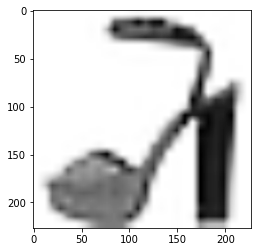

In [11]:
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")
    
# get some random training images
dataiter = iter(training_loader) # iter(호출가능한객체, 반복을끝낼값)
images, labels = dataiter.next() # next() : 반복할 수 있을 때는 해당 값을 출력하고, 반복이 끝났을 때는 기본값을 출력

# create grid of images
img_grid = torchvision.utils.make_grid(images[0]) # make_grid : 이미지의 그리드 생성

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

In [12]:
model = my_resnet.to(device) # to()로 모델에 gpu 사용
criterion = F.nll_loss # nll_loss : negative log likelihood loss
optimizer = optim.Adam(model.parameters()) # model(신경망) 파라미터를 optimizer에 전달해줄 때 nn.Module의 parameters() 메소드를 사용

In [13]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # enumberate() : 인덱스와 원소로 이루어진 튜플(tuple)을 만들어줌
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 항상 backpropagation 하기전에 미분(gradient)을 zero로 만들어주고 시작해야 한다.
        output = model(data)
        loss = criterion(output, target) # criterion = loss_fn
        loss.backward() # Computes the gradient of current tensor w.r.t. graph leaves
        optimizer.step() # step() : 파라미터를 업데이트함
        if (batch_idx + 1) % 30 == 0:
            print("Train Epoch:{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)  # -> mean
        print("\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n".format(
            test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
        print('='*50)

In [15]:
for epoch in range(1, epochs+1):
    train(model, device, training_loader, optimizer, epoch)
    test(model, device, validation_loader)

RuntimeError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 8.00 GiB total capacity; 7.02 GiB already allocated; 0 bytes free; 7.32 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF